In [2]:
#Import our dependencies and Setup 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
 
# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the CSV file 
email_splt_df = pd.read_csv("spam_assassin.csv");
email_splt_df.head()

,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


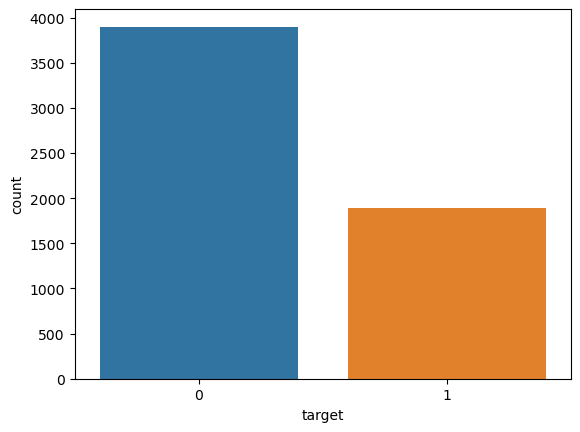

In [4]:
sns.countplot(x="target", data=email_splt_df)
plt.show()

Text(0.5, 0, 'Message types')

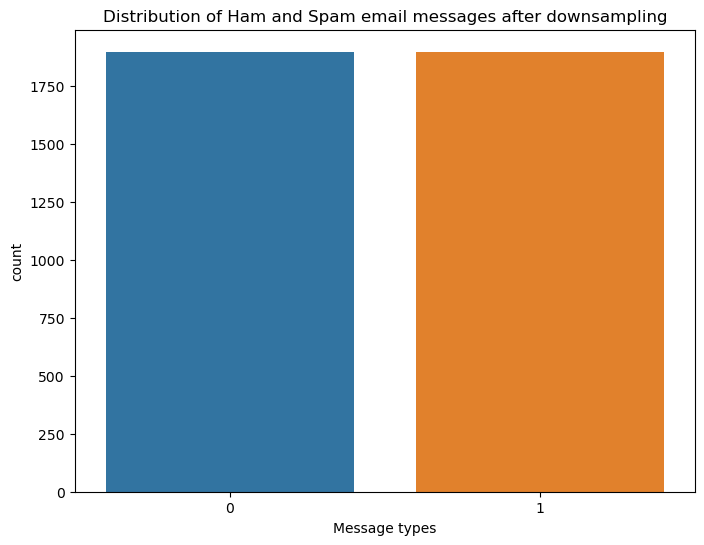

In [5]:
# Downsampling to balance the dataset
ham_msg = email_splt_df[email_splt_df.target == 0]
spam_msg = email_splt_df[email_splt_df.target == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)
 
# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x="target")
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [6]:
# data clensing step
punctuations_list = string.punctuation
punctuations_list


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
# function to remove punctuations prior to splitting words
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,target
0,From rssfeedsjmasonorg Fri Sep 27 104141 2002 ...,0
1,From rssfeedsjmasonorg Tue Sep 24 104734 2002 ...,0
2,ReturnPath gwardpythonnet DeliveryDate Mon Sep...,0
3,From ilugadminlinuxie Tue Aug 6 115453 2002 Re...,0
4,From ilugadminlinuxie Tue Aug 13 102849 2002 R...,0


In [8]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

# Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

        output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,target
0,rssfeedsjmasonorg fri sep 27 104141 2002 retur...,0
1,rssfeedsjmasonorg tue sep 24 104734 2002 retur...,0
2,returnpath gwardpythonnet deliverydate mon sep...,0
3,ilugadminlinuxie tue aug 6 115453 2002 returnp...,0
4,ilugadminlinuxie tue aug 13 102849 2002 return...,0


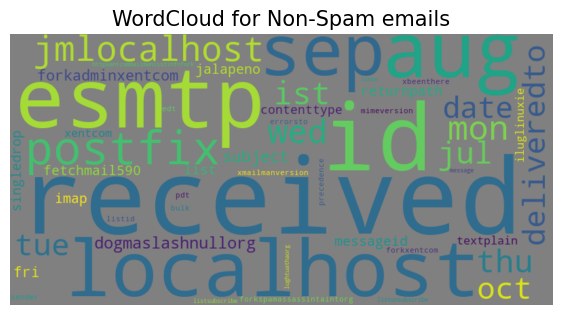

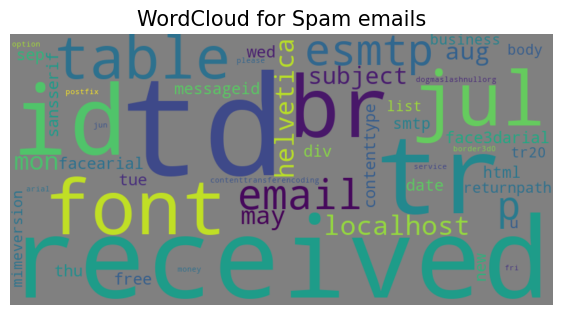

In [9]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='gray',
         max_words=50,
         width=800,
         height=400,
         collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['target'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['target'] == 1], typ='Spam')


In [10]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['target'],
                                                    test_size = 0.2,
                                                    random_state = 42)


In [11]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                 maxlen=max_len,padding='post',truncating='post')
test_sequences = pad_sequences(test_sequences,maxlen=max_len,padding='post',truncating='post')


In [12]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=32,input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           4035136   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4038849 (15.41 MB)
Trainable params: 4038849 (15.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
#Compile the model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),metrics = ['accuracy'],optimizer = 'adam')


In [14]:
es = EarlyStopping(patience=3, monitor = 'val_accuracy',restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,monitor = 'val_loss',factor = 0.5,verbose = 2)


In [15]:
# Train the model
history = model.fit(train_sequences, train_Y,validation_data=(test_sequences, test_Y),epochs=20,batch_size=32,callbacks = [lr, es])


Epoch 1/20
95/95 [==============================] - 5s 38ms/step - loss: 0.4234 - accuracy: 0.8503 - val_loss: 0.2168 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 2/20
95/95 [==============================] - 4s 38ms/step - loss: 0.0619 - accuracy: 0.9829 - val_loss: 0.1173 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 3/20
95/95 [==============================] - 3s 36ms/step - loss: 0.0128 - accuracy: 0.9977 - val_loss: 0.0501 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 4/20
95/95 [==============================] - 4s 38ms/step - loss: 0.0157 - accuracy: 0.9974 - val_loss: 0.0668 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 5/20
95/95 [==============================] - ETA: 0s - loss: 8.5278e-04 - accuracy: 1.0000
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 4s 37ms/step - loss: 8.5278e-04 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 6/20
95/95 [==============================] - 4s 39ms/ste

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


24/24 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9816
Test Loss : 0.06512466818094254
Test Accuracy : 0.9815546870231628


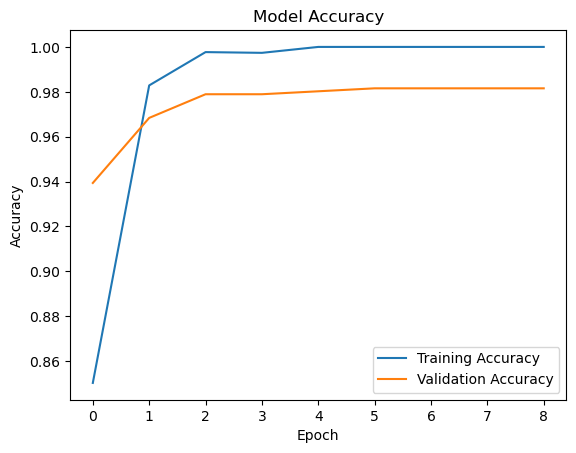

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [18]:
# Save the model
model.save("spam_trained.h5")

In [19]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("spam_trained.h5")